# Periodic structures

GRANAD allows to make an OrbitalList the basis for a periodic simulation

## Setting up the Simulation

We will construct a unit cell for graphene

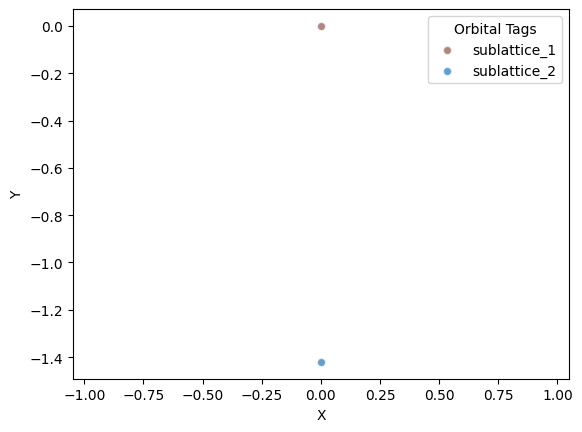

In [1]:
import matplotlib.pyplot as plt

from granad import *

graphene = get_graphene()
flake = graphene.cut_flake(grid_range = [(0,2), (0,1)])
del flake[-1]
del flake[1]
flake.show_2d()

We can make this cell periodic by defining the lattice vectors and the maximum number ofhopping neighbors in our TB model. In GRANAD's standard implementation of graphene, there is hopping between at most nearest neighbors, so we set this number to 1. This number is used to Fourier transform the Hamiltonian and describes an inherent range cutoff. 

In [2]:
lattice_vectors = 2.46 * jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0]
])
fourier_cutoff = 1
bulk = Periodic(flake, lattice_vectors, fourier_cutoff)

We can now plot n repetitions of the unit cell in each periodic dimension

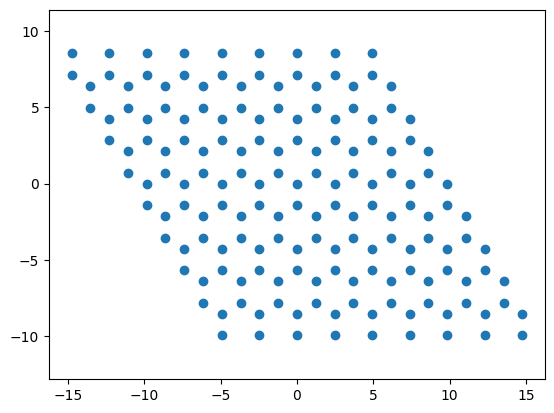

In [3]:
bulk.show_2d(4)

## Band Structures

We can plot graphene's band structure along its high-symmetry path by assessing the reciprocal lattice vectors, which are computed as a property of the bulk

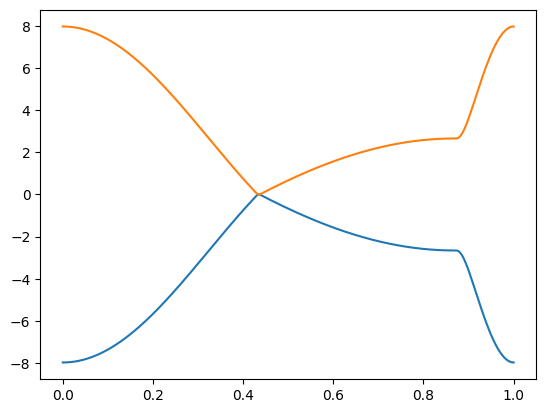

In [4]:
B, A = bulk.reciprocal_basis.T
ks = jnp.concatenate(
    ( jnp.expand_dims(jnp.linspace(0,-1/3,100),1)*A + jnp.expand_dims(jnp.linspace(0,2/3,100),1)*B, # G -> K
      jnp.expand_dims(jnp.linspace(-1/3,0,100),1)*A + jnp.expand_dims(jnp.linspace(2/3,0.5,100),1)*B, # K -> M
      jnp.expand_dims(jnp.linspace(0.5,0,30),1)*B # M -> G          
    )).T

# get eigenvalues along path
energies, eigenvectors = bulk.get_eigenbasis(ks)
plt.plot(jnp.linspace(0, 1, ks.shape[1]), energies)
plt.show()

## Conductivity

We can compute the interband conductivity based on averaging a uniform grid of k-space vectors as follows

In [5]:
# k-space grid
ks = bulk.get_kgrid_monkhorst_pack([200, 200])

# energies and eigenvectors
energies, eigenvectors = bulk.get_eigenbasis(ks)    

# we need the velocity operator in the eigenbasis of the hamiltonian, passing the k-vectors induces this transform
v = bulk.get_velocity_operator(ks, eigenvectors)

# determine chemical potential automatically
mu = bulk.get_mu(energies)

# set temperature to zero
beta = jnp.inf

# frequency grid
omegas = 2.66 * jnp.linspace(0, 2, 100)

c_inter = bulk.get_ip_conductivity_inter(v,
                                         energies,
                                         omegas,
                                         mu,
                                         beta,
                                         relaxation_rate = 0.1)

This returns a W x 3 x 3 array, where W is the number of frequencies and the last two axes are the Cartesian components. We now plot the imaginary part, related to energy transmission

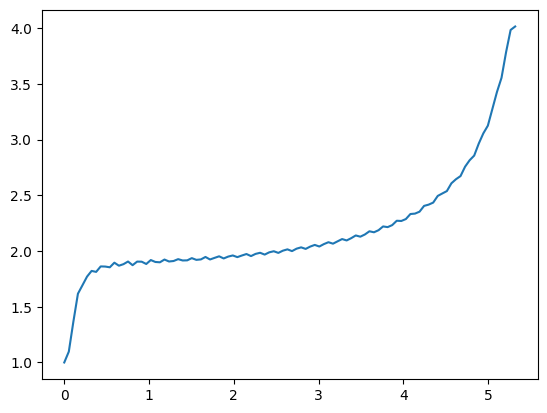

In [6]:
cap = c_inter.imag / c_inter.imag[0]
plt.plot(omegas, cap.diagonal(axis1=1, axis2=2)[:, 0])
plt.show()

The plot gets nicer if more k-points are used. For metals, the intraband / Drude part is important. Consider the example of a 1D metal.

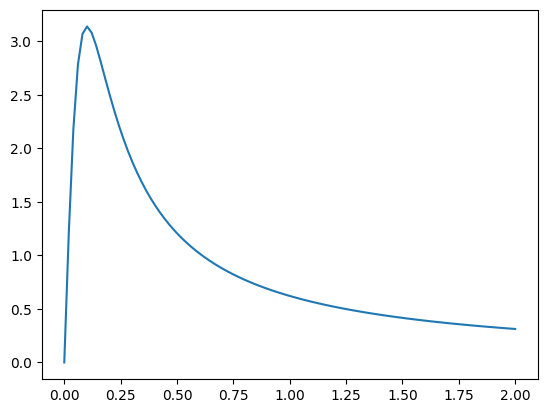

In [7]:
metal = (
Material("Metal")
.lattice_constant(1.0)
.lattice_basis([
    [1, 0, 0],
    [0, 1, 0],
])
.add_orbital_species("up", s = -1)
.add_orbital(position=(0, 0), species = "up",  tag = "up")
.add_interaction(
    "hamiltonian",
    participants=("up", "up"),
    parameters=[0.0, 1.],
)
)
flake = metal.cut_flake(Rectangle(0.5, 0.5), minimum_neighbor_number = 0)
lattice_vectors =  jnp.array([
    [1, 0, 0],
])
bulk = Periodic(flake, lattice_vectors, 2)

grid = jnp.linspace(0, 1, 100)
ks = bulk.reciprocal_basis * grid
vals, vecs = bulk.get_eigenbasis(ks)

v = bulk.get_velocity_operator(ks, vecs)
mu = bulk.get_mu(vals)
omegas = jnp.linspace(0, 2, 100)
c_intra = bulk.get_ip_conductivity_intra(v, vals, omegas, 0, 10, relaxation_rate = 0.1)
cap = c_intra.imag
plt.plot(omegas, cap.diagonal(axis1=1, axis2=2)[:, 0])
plt.show()